In [3]:
!pip install -Uqq fastai
!pip install fastcore
!pip install duckduckgo_search

  Obtaining dependency information for duckduckgo_search from https://files.pythonhosted.org/packages/9d/f3/c7c66f0e767861c4d3105f11a5cd2ec7219f72c710bd766d9b4930e92b81/duckduckgo_search-4.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for curl-cffi>=0.5.10 from https://files.pythonhosted.org/packages/93/04/0d57a51690451437f72563031036ea4f4b529bc0cfd8e8d93487075cbe80/curl_cffi-0.5.10-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.9 MB/s eta 0:00:0000:01:00:01


In [22]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from urllib.request import urlopen

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('metal album covers', max_images=1)
urls[0]

Searching for 'metal album covers'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://static.wixstatic.com/media/96b5ff_0887d402aff741d8904df342819bb631~mv2.jpg/v1/fit/w_1000,h_1000,al_c,q_80/file.jpg'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


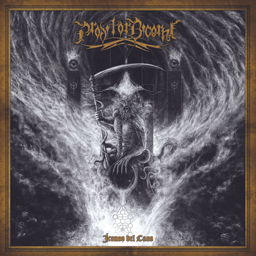

In [6]:
from fastdownload import download_url
dest = 'metal.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'american pop album covers'


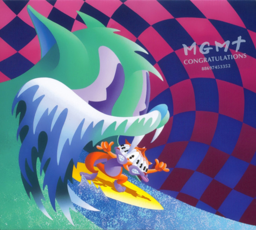

In [9]:
download_url(search_images('american pop album covers', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [27]:
searches = 'metal album','american pop album'
path = Path('metal_or_pop')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(2)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'old {o} photo'))
    sleep(2)
    download_images(dest, urls=search_images(f'new {o} photo'))
    sleep(2)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'metal album photo'
Searching for 'old metal album photo'
Searching for 'new metal album photo'


KeyboardInterrupt: 

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

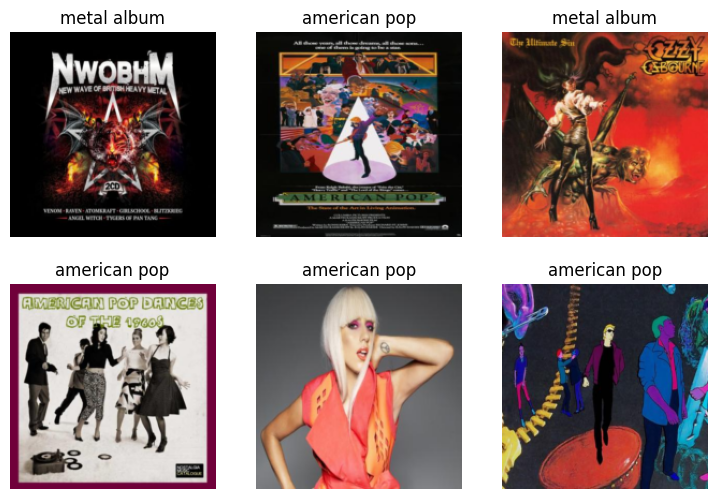

In [13]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 32.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.979131,0.277102,0.112676,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.182706,0.154088,0.042254,00:02
1,0.134609,0.088743,0.028169,00:01
2,0.091294,0.088642,0.042254,00:01


In [26]:
is_metal_album,_,probs = learn.predict(PILImage.create(urlopen("https://upload.wikimedia.org/wikipedia/en/b/be/Murder_of_the_Universe.png")))
print(f"This is a: {is_metal_album}.")
print(f"Probability it's a metal album: {probs[0]:.4f}")

This is a: metal album.
Probability it's a metal album: 0.0002
